# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

Load feature names.

In [4]:
feature_names = []
with open('mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

('Loaded feature names:', 126)


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [5]:
X, Y = [], []

with open('mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

((7000, 126), (1124, 126))


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [6]:
def P1():
    pca = PCA(n_components=50)
    pca.fit(train_data)
    expVar = pca.explained_variance_ratio_
    totalExpVar = np.cumsum(expVar)
    print(pca.components_.shape)
    print(pca.transform(train_data).shape)
    for index, value in enumerate(totalExpVar):
        print("k="+str(1+index)+": ",value)
    
P1()

(50, 126)
(7000, 50)
('k=1: ', 0.16404331279334225)
('k=2: ', 0.29727810148781486)
('k=3: ', 0.39901266670928043)
('k=4: ', 0.46964623105913994)
('k=5: ', 0.50831269456616635)
('k=6: ', 0.54512073764105795)
('k=7: ', 0.57640312866773447)
('k=8: ', 0.60374050219521402)
('k=9: ', 0.62990540688429952)
('k=10: ', 0.65221483256275192)
('k=11: ', 0.67269656209943451)
('k=12: ', 0.69137986869036627)
('k=13: ', 0.70872408901957495)
('k=14: ', 0.72556769547654787)
('k=15: ', 0.74075588342372967)
('k=16: ', 0.75584206770478279)
('k=17: ', 0.77013340274128794)
('k=18: ', 0.78425352905343859)
('k=19: ', 0.79750397644744042)
('k=20: ', 0.8089677659561173)
('k=21: ', 0.81967842442449856)
('k=22: ', 0.83033589086662329)
('k=23: ', 0.84074556259695776)
('k=24: ', 0.85068254786112074)
('k=25: ', 0.85976324650735214)
('k=26: ', 0.8684565088102878)
('k=27: ', 0.87641267616549556)
('k=28: ', 0.88417092168426725)
('k=29: ', 0.89154661843382765)
('k=30: ', 0.89854937805603441)
('k=31: ', 0.90496170956760702

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

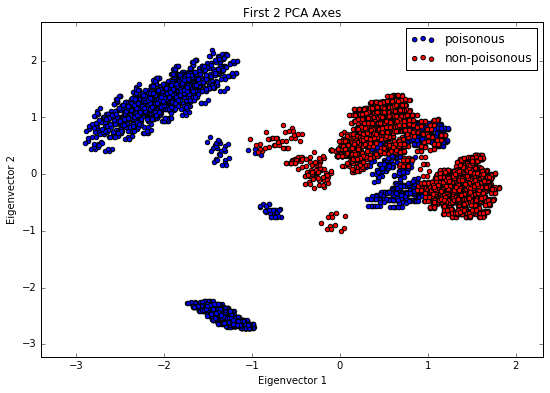

In [7]:
def P2():
    pca = PCA(n_components=2)
    pca.fit(train_data)
    reduced = pca.transform(train_data)
    
    # Plot the training points
    plt.figure(figsize=(9,6))
    plt.scatter(reduced[[index for index, value in enumerate(train_labels) if value==1], 0], 
                reduced[[index for index, value in enumerate(train_labels) if value==1], 1], c="blue", label="poisonous")
    plt.scatter(reduced[[index for index, value in enumerate(train_labels) if value==0], 0], 
                reduced[[index for index, value in enumerate(train_labels) if value==0], 1], c="red", label="non-poisonous")
    plt.xlim(reduced[:,0].min()-.5, reduced[:,0].max()+.5)
    plt.ylim(reduced[:,1].min()-.5, reduced[:,1].max()+.5)
    plt.xlabel('Eigenvector 1')
    plt.ylabel('Eigenvector 2')
    plt.title('First 2 PCA Axes')
    plt.legend()
    plt.show()
P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

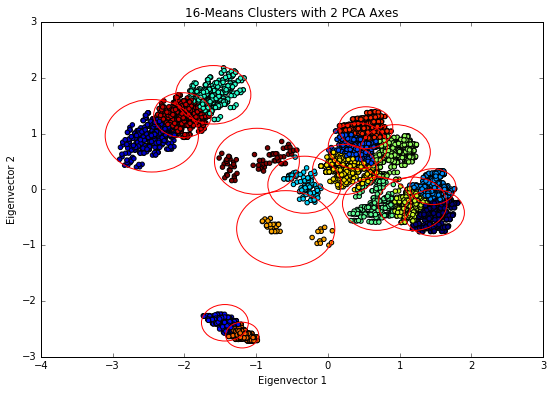

In [8]:
def distance(x, y):
    return np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)


def P3():
    pca = PCA(n_components=2)
    pca.fit(train_data)
    reduced = pca.transform(train_data)
    km = KMeans(n_clusters=16)
    pred = km.fit_predict(reduced)
    plt.figure(figsize=(9,6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=pred)
    dist = [distance(value,km.cluster_centers_[pred[index]]) for index, value in enumerate(reduced)]
    maxes = ndimage.maximum(dist, labels=pred, index=list(set(pred)))
    plt.xlabel('Eigenvector 1')
    plt.ylabel('Eigenvector 2')
    plt.title('16-Means Clusters with 2 PCA Axes')
    for index, center in enumerate(km.cluster_centers_):
        plt.gcf().gca().add_artist(plt.Circle((center[0],center[1]),maxes[index],color='r', fill=False))
    
    plt.show()
    
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

Number of Components: 1


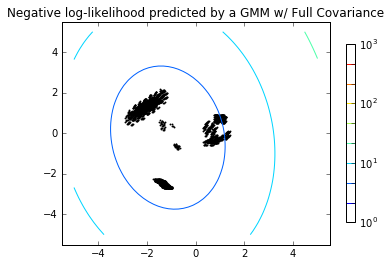

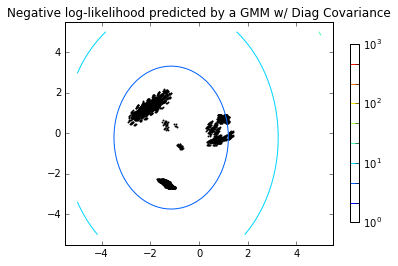

Number of Components: 2


/Users/AnthonySpalvieriKruse/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


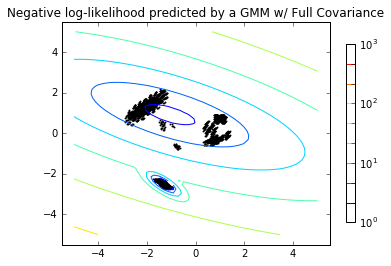

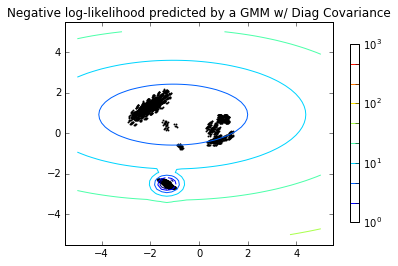

Number of Components: 3


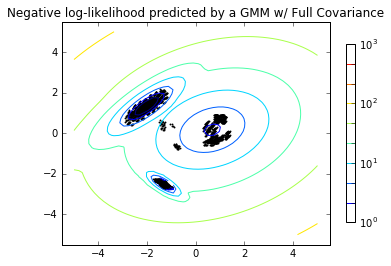

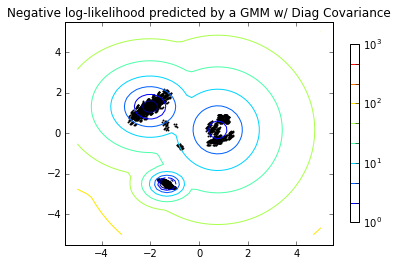

Number of Components: 4


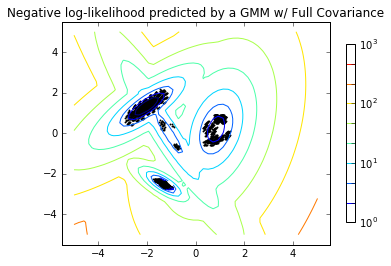

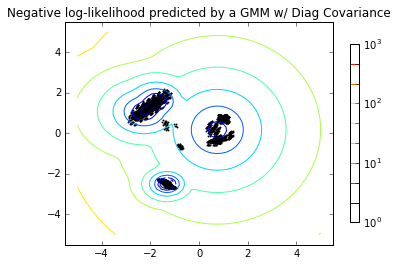

In [9]:
def P4():
    pca = PCA(n_components=2)
    pca.fit(train_data)
    reduced = pca.transform(train_data)
    pos = [ reduced[index] for index, value in enumerate(train_labels) if value==1]
    posIndices = [index for index, value in enumerate(train_labels) if value==1]
    #print(pos)
    
    n_samples=400
    # generate spherical data centered on (20, 20)
    shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

    # generate zero centered stretched Gaussian data
    C = np.array([[0., -0.7], [3.5, .7]])
    stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

    # concatenate the two datasets into the final training set
    X_train = np.vstack([shifted_gaussian, stretched_gaussian])

    for i in range(1,5):
        print("Number of Components: " + str(i))
        
        # fit a Gaussian Mixture Model with two components
        clf = GMM(n_components=i, covariance_type='full')
        clf.fit(pos)

        # display predicted scores by the model as a contour plot
        x = np.linspace(-5.0, 5.0)
        y = np.linspace(-5.0, 5.0)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -clf.score_samples(XX)[0]
        Z = Z.reshape(X.shape)

        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                         levels=np.logspace(0, 3, 10))
        CB = plt.colorbar(CS, shrink=0.8, extend='both')
        plt.scatter(reduced[posIndices, 0], reduced[posIndices, 1], .8)

        plt.title('Negative log-likelihood predicted by a GMM w/ Full Covariance')
        plt.axis('tight')
        plt.show()
        
        clf = GMM(n_components=i, covariance_type='diag')
        clf.fit(pos)
        # display predicted scores by the model as a contour plot
        Z = -clf.score_samples(XX)[0]
        Z = Z.reshape(X.shape)

        CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                         levels=np.logspace(0, 3, 10))
        CB = plt.colorbar(CS, shrink=0.8, extend='both')
        plt.scatter(reduced[posIndices, 0], reduced[posIndices, 1], .8)

        plt.title('Negative log-likelihood predicted by a GMM w/ Diag Covariance')
        plt.axis('tight')
        plt.show()
    
    
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [10]:
def P5():
    pca = PCA(n_components=2)
    pca.fit(train_data)
    reduced = pca.transform(train_data)
    testPCA = pca.transform(test_data)
    pos = [ reduced[index] for index, value in enumerate(train_labels) if value==1]
    neg = [ reduced[index] for index, value in enumerate(train_labels) if value==0]
    clfPos = GMM(n_components=4, covariance_type='full')
    clfPos.fit(pos)
    clfNeg = GMM(n_components=4, covariance_type='full')
    clfNeg.fit(neg)
    
    posPred = clfPos.predict(testPCA)
    negPred = clfNeg.predict(testPCA)
    posScore = clfPos.score(testPCA)
    negScore = clfNeg.score(testPCA)
    
    pred = [1 if posScore[index]>negScore[index] else 0 for index in range(len(testPCA))]
    
    print("Accuracy: ",np.mean(pred == test_labels))

P5()

('Accuracy: ', 0.95106761565836295)


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [11]:
def P6():
    covTypes = ['spherical', 'tied', 'diag', 'full']
    
    for covType in covTypes:
        for numPCA in range(1,5):
            for numGMM in range(1,5):

                pca = PCA(n_components=numPCA)
                pca.fit(train_data)
                reduced = pca.transform(train_data)
                testPCA = pca.transform(test_data)
                pos = [ reduced[index] for index, value in enumerate(train_labels) if value==1]
                neg = [ reduced[index] for index, value in enumerate(train_labels) if value==0]
                clfPos = GMM(n_components=numGMM, covariance_type=covType)
                clfPos.fit(pos)
                clfNeg = GMM(n_components=numGMM, covariance_type=covType)
                clfNeg.fit(neg)
                posScore = clfPos.score(testPCA)
                negScore = clfNeg.score(testPCA)
                pred = [1 if posScore[index]>negScore[index] else 0 for index in range(len(testPCA))]
                print("PCA:",numPCA,"| GMM:",numGMM,"| Covariance:",covType,"| Total Components:",numGMM*2*numPCA*2)
                print("Accuracy: ",np.mean(pred == test_labels),"| Accuracy-Components Ratio:", np.mean(pred == test_labels)/(numGMM*2*numPCA*2))
    
P6()

('PCA:', 1, '| GMM:', 1, '| Covariance:', 'spherical', '| Total Components:', 4)
('Accuracy: ', 0.84430604982206403, '| Accuracy-Components Ratio:', 0.21107651245551601)
('PCA:', 1, '| GMM:', 2, '| Covariance:', 'spherical', '| Total Components:', 8)
('Accuracy: ', 0.89946619217081847, '| Accuracy-Components Ratio:', 0.11243327402135231)
('PCA:', 1, '| GMM:', 3, '| Covariance:', 'spherical', '| Total Components:', 12)
('Accuracy: ', 0.90302491103202842, '| Accuracy-Components Ratio:', 0.075252075919335706)
('PCA:', 1, '| GMM:', 4, '| Covariance:', 'spherical', '| Total Components:', 16)
('Accuracy: ', 0.91370106761565839, '| Accuracy-Components Ratio:', 0.057106316725978649)
('PCA:', 2, '| GMM:', 1, '| Covariance:', 'spherical', '| Total Components:', 8)
('Accuracy: ', 0.86032028469750887, '| Accuracy-Components Ratio:', 0.10754003558718861)
('PCA:', 2, '| GMM:', 2, '| Covariance:', 'spherical', '| Total Components:', 16)
('Accuracy: ', 0.87366548042704628, '| Accuracy-Components Ratio

I would say the optimal parameter set is a tossup between:
    
    PCA: 3 | GMM: 3 | Covariance: tied | Total Components: 36
    Accuracy:  0.963523131673 | Accuracy-Components Ratio: 0.0267645314353
and

    PCA: 2 | GMM: 3 | Covariance: tied | Total Components: 24
    Accuracy:  0.946619217082 | Accuracy-Components Ratio: 0.0394424673784
            
Obviously the model with 36 parameters performs around 2 points better, but it has 12 extra parameters than the 2 PCA model that already achieves a 94.7% accuracy
    